This notebook has the plots to make the received sounds schematic.
Last updated October 2019.

In [144]:
import sys 
sys.path.append('../CPN/')
from the_cocktail_party_nightmare import *

In [269]:
import glob
import dill
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd

In [15]:
%matplotlib notebook

In [16]:
data_stores_in_folder = glob.glob('groupsize*.h5')
datastores_by_index = pd.DataFrame(data={'data_stores':data_stores_in_folder})
print(datastores_by_index)
# user-inputs dataset choice:
which_dataset = int(raw_input('Give the index of the dataset you want to'))
# load a pre-exisiting dataset
#load the saved data 
data_load = pd.HDFStore(data_stores_in_folder[-1])
simulation_data = data_load['simulation_data']
data_load.close()

                           data_stores
0    groupsize_data[2019, 9, 23, 8].h5
1   groupsize_data[2019, 9, 26, 15].h5
2   groupsize_data[2019, 9, 23, 11].h5
3  groupsize_data[2019, 10, 14, 14].h5
4   groupsize_data[2019, 9, 27, 12].h5
Give the index of the dataset you want to3


In [84]:
# choose a group size of 5 bats because it is easy to visualise the concept at a small group size:
one_uuid = simulation_data[simulation_data['group_size']==5]['uuid'].iloc[0]
print(one_uuid)

56763d3c-ba40-4e77-af8b-07fc616961e2


In [85]:
# find the results file with this uuid
results_folder = '../simulations/effect_of_group_size/'
result_file = glob.glob(results_folder+'*'+one_uuid+'*')
print(result_file)

['../simulations/effect_of_group_size/effect_of_groupsize_56763d3c-ba40-4e77-af8b-07fc616961e2_771976893_.simresults']


In [86]:
def load_simresult(path_to_simresult):
    '''
    '''
    with open(path_to_simresult, 'rb') as sim:
        output = dill.load(sim)
    return(output)

In [87]:
simresult = load_simresult(result_file[0])

In [88]:
sim_id, sim_data =  simresult
nbrs_heard, received_sounds, group_geometry = sim_data

In [89]:
received_sounds.keys()

['2dary_echoes', 'target_echoes', 'conspecific_calls']

In [90]:
received_sounds['target_echoes']

,R_incoming,R_outgoing,route,sourcelevel_ref_distance,theta,theta_emission,theta_incoming,theta_outgoing,emitted_SPL,incoming_SPL,reflection_strength,level,start,stop
0,0.502241,0.502241,"(0, 1, 0)",1.0,51.7680,51.7680,-136.2320,-136.2320,97.331930,103.313695,-39.572557,68.960597,544,3043
1,0.625542,0.625542,"(0, 2, 0)",1.0,-116.9742,-116.9742,65.0258,65.0258,89.824875,93.899740,-38.055927,57.011499,1291,3790
2,0.640002,0.640002,"(0, 3, 0)",1.0,152.4444,152.4444,-25.5556,-25.5556,86.794064,90.670442,-38.055927,52.717769,1379,3878
3,0.659303,0.659303,"(0, 4, 0)",1.0,-44.0273,-44.0273,122.9727,122.9727,98.033061,101.651363,-39.572557,65.135124,1496,3995


In [91]:
def gather_plot_data_from_sounddf(sounds):
    '''
    '''
    start, stop = sounds['start'], sounds['stop']    
    level = sounds['level']
    data_to_plot = np.column_stack((start, stop, level))
    return(data_to_plot)

In [204]:
def calculate_masker_SPL_profile(echo, **kwargs):
    '''
    '''
    apply_spatial_unmasking_on_sounds(float(echo['theta']), 
                                          kwargs['other_sounds'], **kwargs)
    cumulative_spl = ipi_soundpressure_levels(kwargs['other_sounds'], 'post_SUM',
                                                                  **kwargs)
    cumulative_dbspl = dB(cumulative_spl)
    return(cumulative_spl, cumulative_dbspl)

In [205]:
echoes_data = gather_plot_data_from_sounddf(received_sounds['target_echoes'])
calls_data = gather_plot_data_from_sounddf(received_sounds['conspecific_calls'])
seconadry_echoes = gather_plot_data_from_sounddf(received_sounds['2dary_echoes'])

In [206]:
spatial_unmasking_data = pd.read_csv('../data/spatial_release_fn.csv')
spatial_unmasking_fn = np.array(spatial_unmasking_data.iloc[:,1:])

In [265]:
other_sounds = pd.concat((received_sounds['conspecific_calls'],received_sounds['2dary_echoes'])).reset_index(drop=True)
other_sounds['post_SUM'] = np.nan
keyword_args = {'simtime_resolution':10**-6, 'other_sounds':other_sounds,
                'spatial_release_fn':spatial_unmasking_fn,
               'interpulse_interval' :0.1}

/home/thejasvib/anaconda2/envs/theCPN/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [266]:
one_echo = received_sounds['target_echoes'].loc[0,:]
masker_spl , masker_dbspl = calculate_masker_SPL_profile(one_echo, **keyword_args)

# just set the lowest sound pressure level to 0 - replace -inf
all_minusinf = masker_dbspl == masker_dbspl[0]
masker_dbspl[all_minusinf] = 0
echo_masker_profile = one_echo['level'] - masker_dbspl

In [267]:
echo_masker_profile

array([68.9605971, 68.9605971, 68.9605971, ..., 68.9605971, 68.9605971,
       68.9605971])

<IPython.core.display.Javascript object>


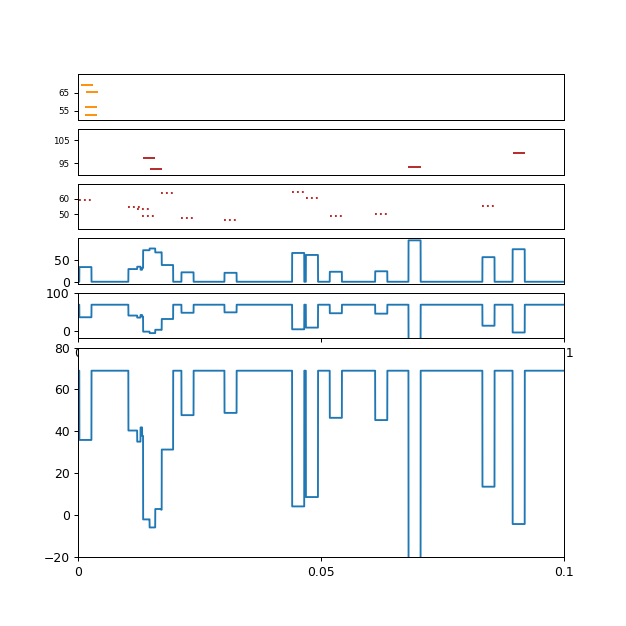

(0, 99999)

In [274]:
ylabel_fontsize = 7
f = plt.figure(figsize=(7,7))

gs = GridSpec(9, 1)
# echoes plot
f.add_subplot(gs[0])
plt.xticks([])
plt.hlines(echoes_data[:,-1],echoes_data[:,0],echoes_data[:,1],color='darkorange')
plt.xlim(0,-1+10**5)
plt.ylim(50,75);plt.yticks([55,65], fontsize=ylabel_fontsize)

# neighbouring bat calls plot
f.add_subplot(gs[1])
plt.xticks([])
plt.hlines(calls_data[:,-1],calls_data[:,0],calls_data[:,1],color='firebrick')
plt.xlim(0,-1+10**5)
plt.ylim(90,110);plt.yticks([95,105], fontsize=ylabel_fontsize)

# secondary echoes plot
f.add_subplot(gs[2])
plt.xticks([])
plt.hlines(seconadry_echoes[:,-1],seconadry_echoes[:,0],seconadry_echoes[:,1],
                         linestyle=':', color='firebrick')
plt.xlim(0,-1+10**5)
plt.ylim(40,70);plt.yticks([50,60], fontsize=ylabel_fontsize)

# masker SPL plot
f.add_subplot(gs[3])
#mock_spl_profile = np.random.choice(np.arange(50,70),100000)
plt.plot(np.arange(10**5),masker_dbspl)
plt.xticks([])
plt.xlim(0,-1+10**5)

# echo-masker SPL plot
f.add_subplot(gs[4])
#mock_spl_profile = np.random.choice(np.arange(-30,-10),100000)
plt.plot(np.arange(10**5),echo_masker_profile, '-')
plt.xticks([0,0.5*10**5,10**5],[0,0.05,0.1])
plt.ylim(-20,100)
plt.xlim(0,-1+10**5)

# zoom-in of temporal masking envelope
f.add_subplot(gs[5:,:])
plt.plot(np.arange(10**5),echo_masker_profile, '-')
plt.xticks([0,0.5*10**5,10**5],[0,0.05,0.1])
plt.ylim(-20,80)
plt.xlim(0,-1+10**5)


